# CS412 - Machine Learning - 2024-2025
## Homework 4


## Dataset
[**CelebA**](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter.

**Download the data from Sucourse and upload it to your Google Drive. You must upload both CelebA30k.zip and CelebA30k.csv to your Drive without renaming them.
CelebA30k is a smaller version of the original CelebA dataset, containing 30,000 images, to reduce computation time during training.
Split the data as follows: reserve 10% of the samples for validation and 10% for testing (i.e., 3,000 samples). The remaining 80% should be used for training.
Important: The test set (3,000 samples) must be used only for final evaluation and not for model selection or hyperparameter tuning.**

## Task

Build a gender classifier using the PyTorch library and a pretrained VGG-16 model on the CelebA dataset. Your goal is to complete the given code without changing the base architecture of VGG-16 (other than replacing the classification head suitable for binary classification).

You will:
- Freeze the convolutional layers of the pretrained model  
- Replace the classifier head with your own binary classification layer  
- Fine-tune the model on the given subset of CelebA  
- Experiment with different values of learning rate, batch size, and number of epochs  

**Dataset:** CelebA  
**Model:** VGG-16
**Library:** PyTorch  

---

## Software

You will use the PyTorch framework for this homework. PyTorch offers flexible tools for deep learning, including pretrained models, custom training loops, and GPU acceleration.

##1) Initialize

*   First make a copy of the notebook given to you as a starter.

*   Make sure you change your runtime to GPU.

## 2) Load training dataset

In [44]:
# load data
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [45]:
# Import necessary libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
import torchvision

from torch.utils.data import DataLoader, Dataset

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [46]:
data = pd.read_csv('/content/drive/My Drive/CelebA30k.csv') # enter the file path on your drive for the csv file
data.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [47]:
gender_data = data[['filename', 'Male']].copy()
gender_data.head()

,filename,Male
0,000001.jpg,-1
1,000002.jpg,-1
2,000003.jpg,1
3,000004.jpg,-1
4,000005.jpg,-1


In [49]:
# This will extract the contents of the zip file into a folder named data
# Do not extract the zip into your google drive

!unzip "/content/drive/My Drive/CelebA30k.zip" -d "/content/data"

Archive:  /content/drive/My Drive/CelebA30k.zip
replace /content/data/CelebA30k/003301.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [50]:
first_image_path = os.path.join("/content/data/CelebA30k/", gender_data.loc[0,"filename"])
img = Image.open(first_image_path)

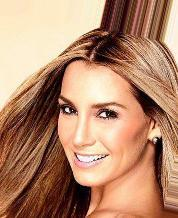

In [51]:
img

# Starting here, you’ll need to fill in the code cells on your own.

##3) Visualizing/Understanding the dataset

- Display five random images together with their labels

- Display statistics about the dataset, such as distribution of labels, etc.


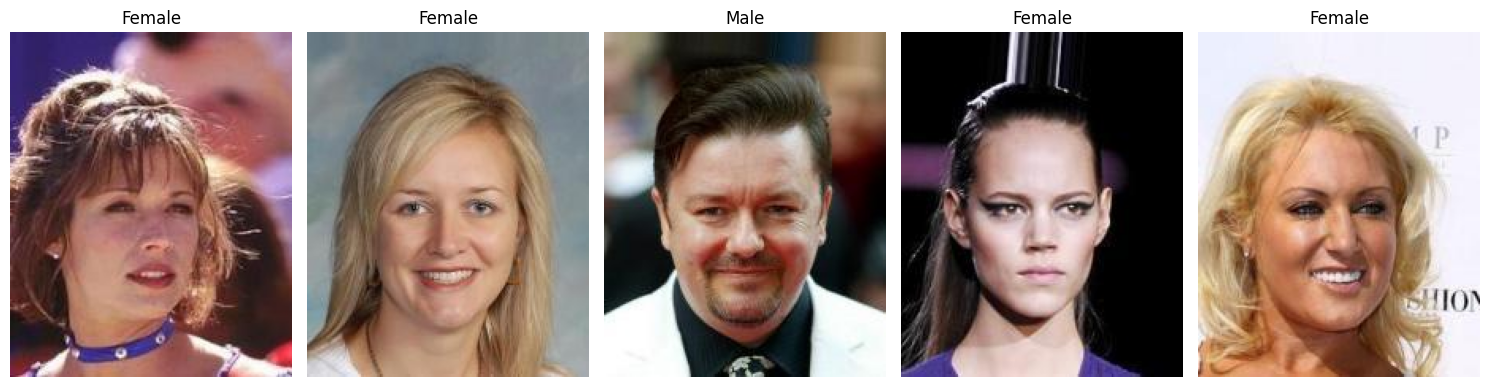

In [53]:
import random

sample_indices = random.sample(range(len(gender_data)), 5)
plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    img_path = os.path.join("/content/data/CelebA30k", gender_data.loc[idx, "filename"])
    label = gender_data.loc[idx, "Male"]

    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title("Male" if label == 1 else "Female")
    plt.axis("off")

plt.tight_layout()
plt.show()

Label counts:
 Male
-1    17320
 1    12680
Name: count, dtype: int64

Label proportions:
 Male
-1    0.577333
 1    0.422667
Name: count, dtype: float64


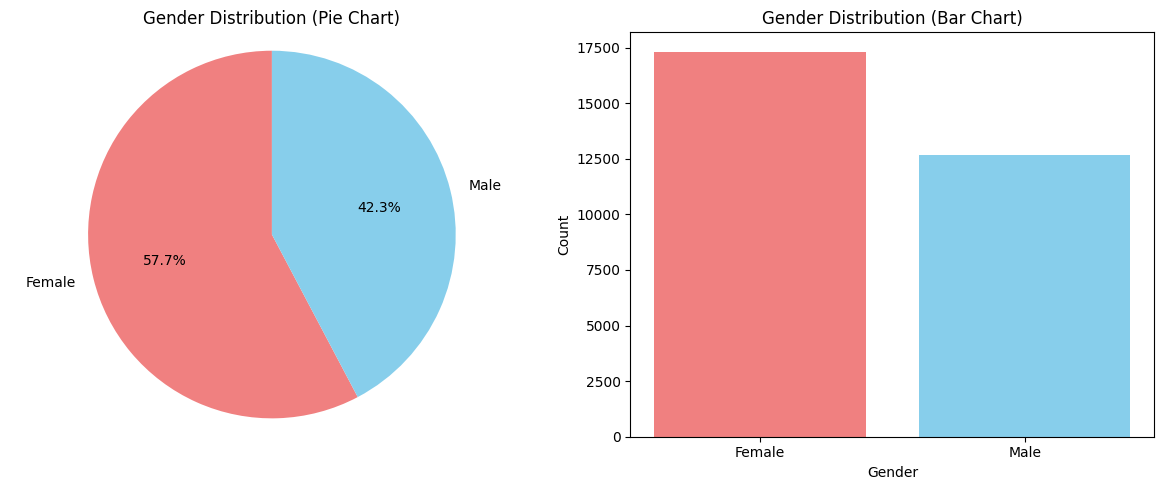

In [54]:
gender_counts = gender_data['Male'].value_counts()
gender_labels = ['Female', 'Male']  # 0: Female, 1: Male

# Statistics
print("Label counts:\n", gender_counts)
print("\nLabel proportions:\n", gender_counts / len(gender_data))

# Pie chart
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(gender_counts, labels=gender_labels, autopct='%1.1f%%', startangle=90, colors=["lightcoral", "skyblue"])
plt.title("Gender Distribution (Pie Chart)")
plt.axis('equal')

# Histogram (Bar Chart)
plt.subplot(1, 2, 2)
plt.bar(gender_labels, gender_counts.values, color=["lightcoral", "skyblue"])
plt.title("Gender Distribution (Bar Chart)")
plt.xlabel("Gender")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


##4) Split the dataset as train (80%), validation (10%) and test (10%) set.

In [55]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(gender_data, test_size=0.2, random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training set size: {len(train_df)} images ({len(train_df)/len(gender_data)*100:.2f}%)")
print(f"Validation set size: {len(val_df)} images ({len(val_df)/len(gender_data)*100:.2f}%)")
print(f"Test set size: {len(test_df)} images ({len(test_df)/len(gender_data)*100:.2f}%)")

print("\nGender distribution in training set:")
print(f"Male: {len(train_df[train_df['Male'] == 1])} ({len(train_df[train_df['Male'] == 1])/len(train_df)*100:.2f}%)")
print(f"Female: {len(train_df[train_df['Male'] == -1])} ({len(train_df[train_df['Male'] == -1])/len(train_df)*100:.2f}%)")

print("\nGender distribution in validation set:")
print(f"Male: {len(val_df[val_df['Male'] == 1])} ({len(val_df[val_df['Male'] == 1])/len(val_df)*100:.2f}%)")
print(f"Female: {len(val_df[val_df['Male'] == -1])} ({len(val_df[val_df['Male'] == -1])/len(val_df)*100:.2f}%)")

print("\nGender distribution in test set:")
print(f"Male: {len(test_df[test_df['Male'] == 1])} ({len(test_df[test_df['Male'] == 1])/len(test_df)*100:.2f}%)")
print(f"Female: {len(test_df[test_df['Male'] == -1])} ({len(test_df[test_df['Male'] == -1])/len(test_df)*100:.2f}%)")

Training set size: 24000 images (80.00%)
Validation set size: 3000 images (10.00%)
Test set size: 3000 images (10.00%)

Gender distribution in training set:
Male: 10155 (42.31%)
Female: 13845 (57.69%)

Gender distribution in validation set:
Male: 1251 (41.70%)
Female: 1749 (58.30%)

Gender distribution in test set:
Male: 1274 (42.47%)
Female: 1726 (57.53%)


## 5) Preparing the Data

In this section, you will implement the dataset loading and preprocessing pipeline using PyTorch.

You are provided with:
- `train_df` and `val_df` dataframes, which include two columns: `filename`  and `Male`
- A directory path (`/content/data/CelebA30k`) that contains the image files

Your task is to:
1. Define appropriate transformations using `torchvision.transforms` for the training and validation sets
   - Resize images to 224x224
   - Convert them to tensors
   - Normalize them (you can use `[0.5], [0.5]` for simplicity)
   - Add data augmentation (e.g., horizontal flip) for training
2. Write a custom `Dataset` class that reads images and labels from the dataframe
3. Create `DataLoader` objects for training and validation with an appropriate batch size

In [56]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [57]:
class CelebADataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        label = 1.0 if self.dataframe.iloc[idx, 1] == 1 else 0.0

        if self.transform:
            image = self.transform(image)

        return image, label

In [58]:
# Dataset objects
train_dataset = CelebADataset(train_df, "/content/data/CelebA30k", transform=train_transform)
val_dataset   = CelebADataset(val_df,   "/content/data/CelebA30k", transform=val_transform)
test_dataset = CelebADataset(test_df, "/content/data/CelebA30k/", transform=val_transform)


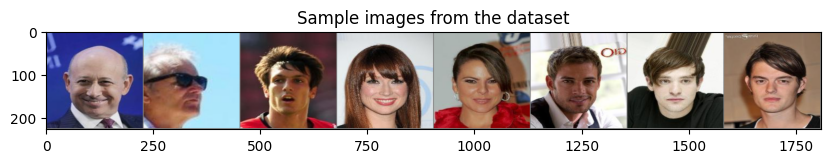

Labels: ['Male', 'Male', 'Male', 'Female', 'Female', 'Male', 'Male', 'Male']


In [60]:
# DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 5))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title='Sample images from the dataset')
print(f"Labels: {['Male' if c == 1.0 else 'Female' for c in classes[:8]]}")

## 6) Transfer Learning with VGG-16

We will create the base model from the well-known VGG-16 architecture available in torchvision.models. This model is pretrained on the ImageNet dataset, a large dataset containing 1.4 million images and 1,000 object categories.

In transfer learning, we use the convolutional base of the pretrained model as a feature extractor. However, we do not use the last fully connected layer, which is specific to ImageNet’s 1,000-class classification task. Instead, we will:
- Keep the convolutional layers (which extract general visual features)
- Remove the final classification layer
- Replace it with our own binary classifier (for gender classification)

This is a common strategy because the layer before the original classification head (the so-called "bottleneck layer") retains high-level, general features useful for a wide range of vision tasks.

### Instructions

You should:
1. Load the VGG-16 model with pretrained=True from torchvision.models.
2. Replace the classifier head with a new sequence of layers suitable for binary classification:
   - The final output should have one neuron (output dimension = 1).
   - Do not apply a Sigmoid activation after the output layer, because the loss function you will use internally applies it.


In [61]:
def get_vgg16_model(fine_tune_last_block=False):
    # Load the pretrained VGG-16 model from torchvision
    model = models.vgg16(pretrained=True)

    # Freeze all parameters initially
    for param in model.parameters():
        param.requires_grad = False

    if fine_tune_last_block:
        # Unfreeze only the last convolutional block (conv5)
        for name, param in model.features.named_parameters():
            if int(name.split('.')[0]) >= 24:
                param.requires_grad = True
        print("Fine-tuning enabled: last convolutional block is trainable.")
    else:
        print("All convolutional layers are frozen (feature extractor mode).")

    # Replace the classifier head for binary classification (output = 1)
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 1)  # Binary output
    )

    return model


## 7) Fine-Tuning and Training the Model

Now that your VGG-16 base model is set up with a new binary classification head, it’s time to fine-tune and train it using your `train_loader` and evaluate it using your `val_loader`.

You will:
- Experiment with two different fine-tuning strategies:
  - Freeze all convolutional layers and train only the classifier head.
  - Unfreeze the last convolutional block and the classifier head, and train them.
- Choose an appropriate optimizer (e.g., `torch.optim.SGD` or `Adam`).
- Use `nn.BCEWithLogitsLoss()` as the loss function.
  - Note: Since you are using nn.BCEWithLogitsLoss(), your model's output should not have a Sigmoid activation. This loss function applies the Sigmoid operation internally.
- Implement a training loop that includes validation after each epoch.
- Monitor both training and validation performance across epochs.

Hyperparameter Tuning:
- Try two different learning rates: 0.001 and 0.0001.
- The number of training epochs must be fixed to 10.
- You may adjust batch size depending on available GPU memory, but typically 32 or 64 is suggested.

Finally, you should report:
- Final training and validation accuracy for each configuration.
- A plot showing training and validation loss across epochs.
- A brief discussion comparing the results for different fine-tuning strategies and learning rates, identifying which combination performed best and why.


In [65]:
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Train and validate the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model = model.to(device)
    start_time = time.time()

    # Lists to store loss and accuracy
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        epoch_start = time.time()

        # --- Training phase ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs).squeeze()  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            # Compute training accuracy
            running_loss += loss.item() * inputs.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # --- Validation phase ---
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = correct / total
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc)

        epoch_end = time.time()

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_losses[-1]:.4f} | '
              f'Train Acc: {train_accs[-1]:.4f} | '
              f'Val Loss: {val_losses[-1]:.4f} | '
              f'Val Acc: {val_accs[-1]:.4f} | '
              f'Time: {epoch_end-epoch_start:.2f}s')

    total_time = time.time() - start_time
    print(f'Training complete in {total_time//60:.0f}m {total_time%60:.0f}s')

    return model, train_losses, val_losses, train_accs, val_accs

# Plot loss and accuracy over epochs
def plot_metrics(train_losses, val_losses, train_accs, val_accs, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'Training and Validation Loss - {title}')
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.plot(train_accs, label='Training Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'Training and Validation Accuracy - {title}')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot confusion matrix after evaluation
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.xticks([0.5, 1.5], ['Female', 'Male'])
    plt.yticks([0.5, 1.5], ['Female', 'Male'])
    plt.tight_layout()
    plt.show()

# Binary loss function for classification
criterion = nn.BCEWithLogitsLoss()
results = {}

# --- Experiment 1 ---
print("\nExperiment 1: All convolutional layers frozen, learning rate = 0.001")
model1 = get_vgg16_model(fine_tune_last_block=False)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

model1, train_losses1, val_losses1, train_accs1, val_accs1 = train_model(
    model1, train_loader, val_loader, criterion, optimizer1, num_epochs=10
)

results['exp1'] = {
    'model': model1,
    'train_losses': train_losses1,
    'val_losses': val_losses1,
    'train_accs': train_accs1,
    'val_accs': val_accs1,
    'description': 'Frozen Conv, LR=0.001'
}

# --- Experiment 2 ---
print("\nExperiment 2: All convolutional layers frozen, learning rate = 0.0001")
model2 = get_vgg16_model(fine_tune_last_block=False)
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)

model2, train_losses2, val_losses2, train_accs2, val_accs2 = train_model(
    model2, train_loader, val_loader, criterion, optimizer2, num_epochs=10
)

results['exp2'] = {
    'model': model2,
    'train_losses': train_losses2,
    'val_losses': val_losses2,
    'train_accs': train_accs2,
    'val_accs': val_accs2,
    'description': 'Frozen Conv, LR=0.0001'
}

# --- Experiment 3 ---
print("\nExperiment 3: Last convolutional block fine-tuned, learning rate = 0.001")
model3 = get_vgg16_model(fine_tune_last_block=True)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

model3, train_losses3, val_losses3, train_accs3, val_accs3 = train_model(
    model3, train_loader, val_loader, criterion, optimizer3, num_epochs=10
)

results['exp3'] = {
    'model': model3,
    'train_losses': train_losses3,
    'val_losses': val_losses3,
    'train_accs': train_accs3,
    'val_accs': val_accs3,
    'description': 'Fine-tuned Last Block, LR=0.001'
}

# --- Experiment 4 ---
print("\nExperiment 4: Last convolutional block fine-tuned, learning rate = 0.0001")
model4 = get_vgg16_model(fine_tune_last_block=True)
optimizer4 = optim.Adam(model4.parameters(), lr=0.0001)

model4, train_losses4, val_losses4, train_accs4, val_accs4 = train_model(
    model4, train_loader, val_loader, criterion, optimizer4, num_epochs=10
)

results['exp4'] = {
    'model': model4,
    'train_losses': train_losses4,
    'val_losses': val_losses4,
    'train_accs': train_accs4,
    'val_accs': val_accs4,
    'description': 'Fine-tuned Last Block, LR=0.0001'
}



Experiment 1: All convolutional layers frozen, learning rate = 0.001
All convolutional layers are frozen (feature extractor mode).
Epoch 1/10 | Train Loss: 0.2536 | Train Acc: 0.9148 | Val Loss: 0.1728 | Val Acc: 0.9383 | Time: 101.59s
Epoch 2/10 | Train Loss: 0.2056 | Train Acc: 0.9326 | Val Loss: 0.1471 | Val Acc: 0.9463 | Time: 101.46s
Epoch 3/10 | Train Loss: 0.1708 | Train Acc: 0.9437 | Val Loss: 0.1387 | Val Acc: 0.9527 | Time: 101.50s
Epoch 4/10 | Train Loss: 0.1681 | Train Acc: 0.9463 | Val Loss: 0.1645 | Val Acc: 0.9443 | Time: 101.44s
Epoch 5/10 | Train Loss: 0.1452 | Train Acc: 0.9546 | Val Loss: 0.1375 | Val Acc: 0.9517 | Time: 101.45s
Epoch 6/10 | Train Loss: 0.1430 | Train Acc: 0.9566 | Val Loss: 0.1647 | Val Acc: 0.9437 | Time: 101.50s
Epoch 7/10 | Train Loss: 0.1240 | Train Acc: 0.9604 | Val Loss: 0.1408 | Val Acc: 0.9527 | Time: 101.43s
Epoch 8/10 | Train Loss: 0.1283 | Train Acc: 0.9617 | Val Loss: 0.1371 | Val Acc: 0.9583 | Time: 101.45s
Epoch 9/10 | Train Loss: 0.1

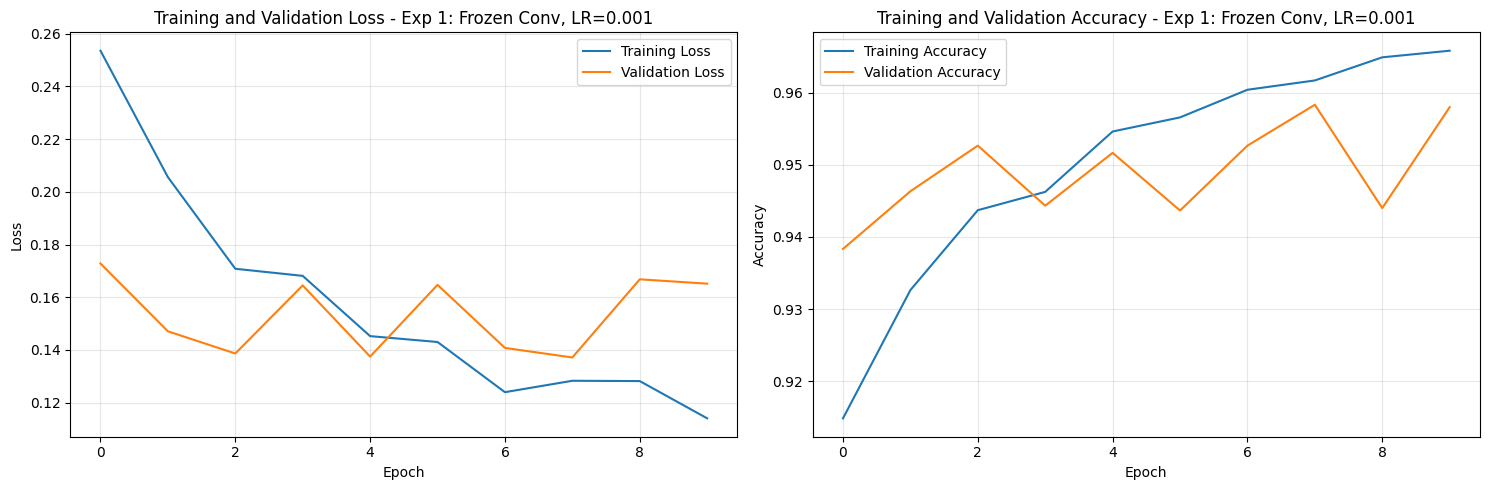

In [66]:
plot_metrics(train_losses1, val_losses1, train_accs1, val_accs1, "Exp 1: Frozen Conv, LR=0.001")

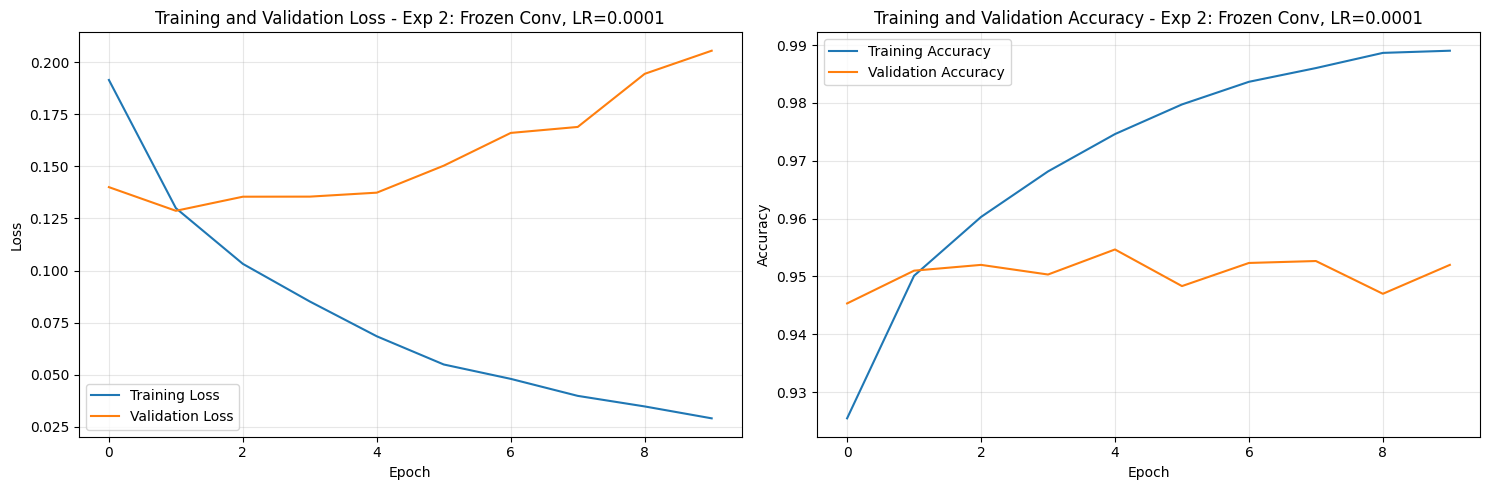

In [67]:
plot_metrics(train_losses2, val_losses2, train_accs2, val_accs2, "Exp 2: Frozen Conv, LR=0.0001")

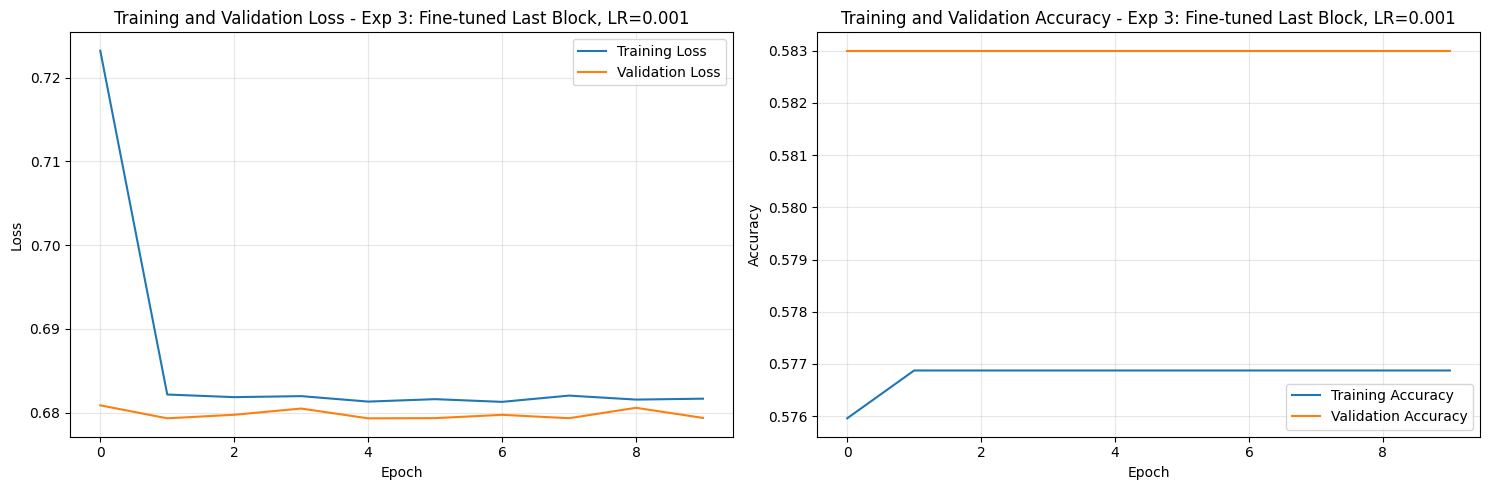

In [68]:
plot_metrics(train_losses3, val_losses3, train_accs3, val_accs3, "Exp 3: Fine-tuned Last Block, LR=0.001")

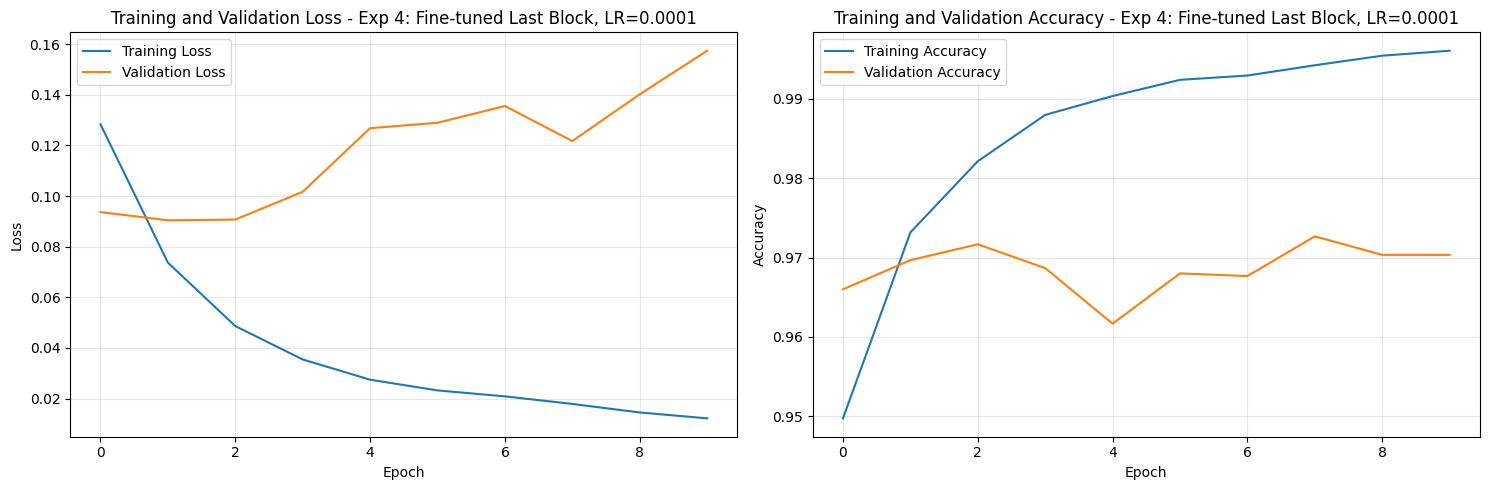

In [69]:
plot_metrics(train_losses4, val_losses4, train_accs4, val_accs4, "Exp 4: Fine-tuned Last Block, LR=0.0001")

In [72]:
print("\nSummary of Results:")
print(f"Experiment 1 (Frozen Conv, LR=0.001): Train Acc = {train_accs1[-1]:.4f}, Val Acc = {val_accs1[-1]:.4f}")
print(f"Experiment 2 (Frozen Conv, LR=0.0001): Train Acc = {train_accs2[-1]:.4f}, Val Acc = {val_accs2[-1]:.4f}")
print(f"Experiment 3 (Fine-tuned Last Block, LR=0.001): Train Acc = {train_accs3[-1]:.4f}, Val Acc = {val_accs3[-1]:.4f}")
print(f"Experiment 4 (Fine-tuned Last Block, LR=0.0001): Train Acc = {train_accs4[-1]:.4f}, Val Acc = {val_accs4[-1]:.4f}")


Summary of Results:
Experiment 1 (Frozen Conv, LR=0.001): Train Acc = 0.9658, Val Acc = 0.9580
Experiment 2 (Frozen Conv, LR=0.0001): Train Acc = 0.9890, Val Acc = 0.9520
Experiment 3 (Fine-tuned Last Block, LR=0.001): Train Acc = 0.5769, Val Acc = 0.5830
Experiment 4 (Fine-tuned Last Block, LR=0.0001): Train Acc = 0.9960, Val Acc = 0.9703


## 8) Test your classifier on Test set

- Use your model to predict the labels of the test set and report the final accuracy.

In [71]:
# Best model: Experiment 4
best_model = results['exp4']['model']
best_model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model(images).squeeze()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.9803



Test Accuracy: 0.9803

Classification Report:
              precision    recall  f1-score   support

      Female       0.98      0.99      0.98      1726
        Male       0.98      0.97      0.98      1274

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



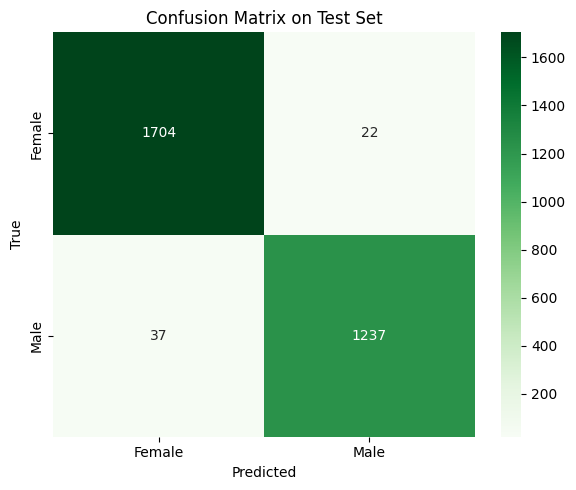

In [77]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set model to evaluation mode
best_model = results['exp4']['model']
best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model(images).squeeze()
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to integers
all_preds = [int(p) for p in all_preds]
all_labels = [int(l) for l in all_labels]

# Accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Female', 'Male']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.show()
